# Codice per la valutazione del progetto

In [1]:
# Packege principali
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Rimpiazzo NaN
from sklearn.impute import KNNImputer

# ELimino Outliers Multivariati
from collections import Counter
from sklearn.cluster import DBSCAN

# Spit Dati
import sklearn.model_selection as model_select
import sklearn.metrics as metrics

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Salvataggio Classificatore
import pickle

In [2]:
# Creiamo la classe che rimpiazza gli outliers che ci servira per pipeline e perchè KNN non rimpiazza direttamente gli outliers
# ma i nan quindi bisogna anche ricreare il metodo fit e il trasform

class KNNReplacerIQR(KNNImputer):
    """Pipeline-compliant KNNReplacer, based on IQR."""

    def __init__(self, n_neighbors=2):
        super().__init__(n_neighbors=n_neighbors)
        self.lower_bound = None
        self.upper_bound = None
        self.imputer = KNNImputer(n_neighbors=n_neighbors)

    def fit(self, x, y=None):
        """Computes IQR bound and fits the imputer on the data."""
        x = pd.DataFrame(x)
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - (1.5* iqr)
        self.upper_bound = q3 + (1.5* iqr)
        self.imputer.fit(
            x.where(~((x < self.lower_bound) | (x > self.upper_bound)), np.nan)
        )
        return self

    def transform(self, x, y=None):
        """Detects outliers and replaces them with the imputer."""
        x = pd.DataFrame(x)
        x.where(~((x < self.lower_bound) | (x > self.upper_bound)),
                np.nan,
                inplace=True)
        return self.imputer.transform(x)

In [3]:
def show_confusion_matrix(cm, f1_score, title):
    """Displays confusion matrix with annotations."""
    # Create annotations label.
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages =\
        ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    box_labels =\
        [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])
    # Show confusion matrix with heat map.
    sns.heatmap(cm,
                annot=box_labels,
                fmt="",
                cmap="YlGnBu",
                cbar=False,
                linewidths=1.0)\
        .set(title=title,
             xlabel='Predicted class\nF1 macro: %0.4f' % f1_score,
             ylabel='Actual class')
    plt.show()

In [8]:
def evaluate_classifier(classifier,imputer,cluster, data_x, data_y, matrix_title='', show=True):
    """Preprocesses test set and evaluates classifiers."""
    data_x = imputer.transform(data_x)
    X_imputer = pd.DataFrame(data_x)
    Scanner = cluster.fit(X_imputer)
    Outliers =X_imputer[Scanner.labels_==-1].index.values
    x_fin = pd.DataFrame(X_imputer).replace(to_replace = Outliers,value = np.nan)
    imputer.fit(x_fin)
    x_final = imputer.fit(x_fin).transform(x_fin)
    pred_y = classifier.predict(x_final)
    confusion_matrix = metrics.confusion_matrix(data_y, pred_y)
    f1_score = metrics.f1_score(data_y, pred_y, average='macro')
    print('\nTest set F1 macro score: %0.4f .\n' % f1_score)
    if show:
        show_confusion_matrix(confusion_matrix, f1_score, matrix_title)
    return f1_score

In [9]:
def evaluation():
    # Load our classifier.
    with open('imputer.sav', 'rb') as model_file:
        imputer = pickle.load(model_file)
    with open('cluster.sav', 'rb') as model_file:
        cluster = pickle.load(model_file)
    with open('best_classificatore.sav', 'rb') as model_file:
        best_pipeline = pickle.load(model_file)

    # Load test set.
    testset_path = str(input("Enter test set file name: "))
    testset = pd.read_csv(testset_path)
    print("TEST SET IMPORTED")

    # Separate features and labels.
    x = testset.drop('CLASS', axis=1)
    y = testset['CLASS']
    
    evaluate_classifier(best_pipeline,imputer,cluster, x, y)

Enter test set file name:  training_set1.csv


TEST SET IMPORTED

Test set F1 macro score: 0.8925 .



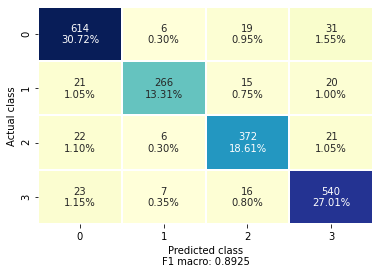

In [11]:
# Start the script.
if __name__ == '__main__':
    evaluation()